Compute & save projections of surrogate neural activity onto top PCs for all behavior trials.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import zscore
from disp import set_font_size, set_plot

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

In [2]:
NR = 224  # original number of responses
NTR = 276  # number of trials

R_COLS = [f'R_{ir}' for ir in range(NR)]

LOAD_DIR = 'data/simple/mlv_c/neur_basic/c_baker_dyn'
LOAD_PFX = 'mlv_c_baker_dyn_tr'
SAVE_DIR = 'data/simple/mlv_c/neur_basic/c_baker_dyn_pca'
SAVE_PFX = 'mlv_c_baker_dyn_pca'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [ ]:
# load all neural data into giant matrix
r_all = []
tr_lens = []

print('Loading...')
for itr in range(NTR):
    df = np.load(f'{os.path.join(LOAD_DIR, LOAD_PFX)}_{itr}.npy', allow_pickle=True)[0]['df']
    tr_lens.append(len(df))
    r_all.append(np.array(df[R_COLS]).astype(np.float32))

r_all = cc(r_all)

r_mn = np.nanmean(r_all, axis=0)
r_std = np.nanstd(r_all, axis=0)

r_all = zscore(r_all)
tr_lens = np.array(tr_lens)

# do pca
print('Fitting...')
pca = PCA().fit(r_all)

# save mean, std, and PCs
np.save(
    os.path.join(SAVE_DIR, 'pca_results.npy'),
    np.array([{
        'r_mn': r_mn, 'r_std': r_std, 'pcs': pca.components_, 'expl_var': pca.explained_variance_ratio_}]))

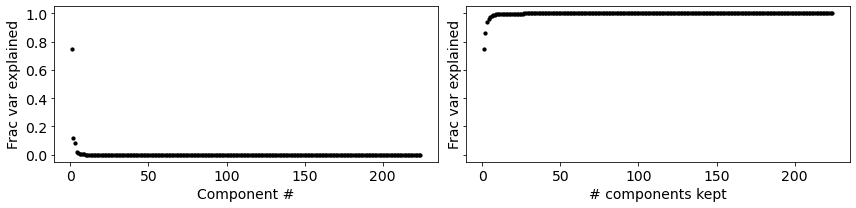

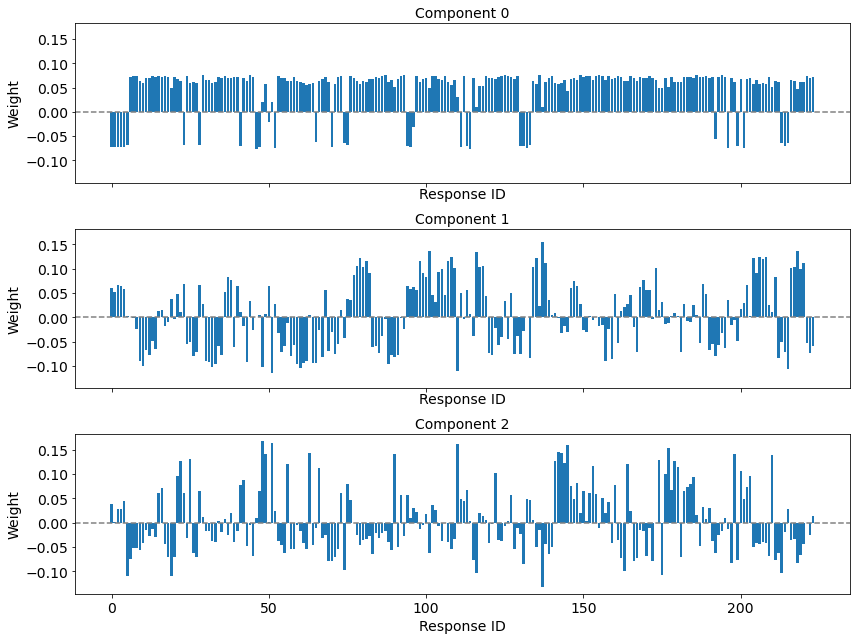

In [4]:
# plot PCA results
fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=True, tight_layout=True)

axs[0].scatter(1+np.arange(NR), pca.explained_variance_ratio_, c='k', lw=2, s=5)
axs[1].scatter(1+np.arange(NR), pca.explained_variance_ratio_.cumsum(), c='k', lw=2, s=5)

set_plot(axs[0], x_label='Component #', y_label='Frac var explained', font_size=14)
set_plot(axs[1], x_label='# components kept', y_label='Frac var explained', font_size=14)

fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True, sharey=True, tight_layout=True)
for ccomponent, (component, ax) in enumerate(zip(pca.components_, axs)):
    ax.bar(np.arange(NR), component)
    ax.axhline(0, color='gray', ls='--')
    set_plot(ax, x_label='Response ID', y_label='Weight', title=f'Component {ccomponent}', font_size=14)

In [6]:
# resave all trials using all PCs
SAVE_DIR = 'data/simple/mlv_c/neur_basic/c_baker_dyn_pca_full'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    
NON_R_COLS = ['ID', 'FRAME', 'T', 'Q', 'S', 'P', 'F', 'FFV', 'FFA', 'FLS', 'FRS']

istarts = cc([[0], tr_lens.cumsum()[:-1]])
iends = tr_lens.cumsum()

print('Saving PC projections...\n')
for itr, (istart, iend) in enumerate(zip(istarts, iends)):
    sys.stdout.write('.')
    pc_activities = pca.transform(r_all[istart:iend])
    
    df_nrl = np.load(f'{os.path.join(LOAD_DIR, LOAD_PFX)}_{itr}.npy', allow_pickle=True)[0]['df']
    df_pc = df_nrl[NON_R_COLS]
    
    for ipc, pc_activity in enumerate(pc_activities.T):
        df_pc[f'PC_{ipc}'] = pc_activity
        
    np.save(f'{os.path.join(SAVE_DIR, SAVE_PFX)}_tr_{itr}.npy', np.array([{'df': df_pc}]))

Saving PC projections...

....................................................................................................................................................................................................................................................................................